In [ ]:
# 3. Google Drive Bağlantısı
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 1. Gerekli Kütüphaneleri İçe Aktarma
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from functools import partial
from timm.models.vision_transformer import VisionTransformer, _cfg
from timm.models.layers import trunc_normal_

In [ ]:
# Veri seti yolu
data_dir = "/content/drive/MyDrive/Dataset"  # Kendi veri seti dizininizi girin


In [ ]:
# 4. Veri Seti Hazırlığı
batch_size = 32

# Transformations
common_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Veri setlerini yükleme
train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=common_transform)
val_dataset = datasets.ImageFolder(root=f"{data_dir}/validation", transform=common_transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=common_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# 2. DeiT Tiny Modelini Tanımlama
class DistilledVisionTransformer(VisionTransformer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.dist_token = nn.Parameter(torch.zeros(1, 1, self.embed_dim))
        num_patches = self.patch_embed.num_patches
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 2, self.embed_dim))
        self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if self.num_classes > 0 else nn.Identity()

        trunc_normal_(self.dist_token, std=.02)
        trunc_normal_(self.pos_embed, std=.02)
        self.head_dist.apply(self._init_weights)

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        dist_token = self.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)

        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return x[:, 0], x[:, 1]

    def forward(self, x):
        x, x_dist = self.forward_features(x)
        x = self.head(x)
        x_dist = self.head_dist(x_dist)
        if self.training:
            return x, x_dist
        else:
            return (x + x_dist) / 2


def deit_tiny_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=192, depth=12, num_heads=3, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        checkpoint = torch.hub.load_state_dict_from_url(
            url="https://dl.fbaipublicfiles.com/deit/deit_tiny_patch16_224-a1311bcf.pth",
            map_location="cpu", check_hash=True
        )
        model.load_state_dict(checkpoint["model"])
    return model

In [ ]:
# 5. Modeli Hazırlama
num_classes = len(train_dataset.classes)  # Veri setinizin sınıf sayısı
model = deit_tiny_patch16_224(pretrained=True)
model.head = nn.Linear(model.head.in_features, num_classes)

# GPU kullanımı (varsa)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Kayıp fonksiyonu ve optimizasyon
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

Downloading: "https://dl.fbaipublicfiles.com/deit/deit_tiny_patch16_224-a1311bcf.pth" to /root/.cache/torch/hub/checkpoints/deit_tiny_patch16_224-a1311bcf.pth
100%|██████████| 21.9M/21.9M [00:00<00:00, 81.7MB/s]


In [ ]:
import matplotlib.pyplot as plt

# Kayıp ve doğruluk izleme listeleri
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    # Eğitim döngüsü
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Doğrulama döngüsü
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
          f"Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")


Epoch 1/10, Train Loss: 0.0160, Val Loss: 1.2307, Train Acc: 0.9949, Val Acc: 0.7673
Epoch 2/10, Train Loss: 0.0154, Val Loss: 1.4867, Train Acc: 0.9952, Val Acc: 0.7277
Epoch 3/10, Train Loss: 0.0149, Val Loss: 1.1961, Train Acc: 0.9947, Val Acc: 0.7693
Epoch 4/10, Train Loss: 0.0131, Val Loss: 1.3743, Train Acc: 0.9962, Val Acc: 0.7550
Epoch 5/10, Train Loss: 0.0141, Val Loss: 1.0483, Train Acc: 0.9956, Val Acc: 0.7730
Epoch 6/10, Train Loss: 0.0128, Val Loss: 1.0427, Train Acc: 0.9968, Val Acc: 0.7550
Epoch 7/10, Train Loss: 0.0129, Val Loss: 1.4827, Train Acc: 0.9958, Val Acc: 0.7655
Epoch 8/10, Train Loss: 0.0079, Val Loss: 1.4984, Train Acc: 0.9975, Val Acc: 0.7311
Epoch 9/10, Train Loss: 0.0151, Val Loss: 1.2460, Train Acc: 0.9957, Val Acc: 0.7773
Epoch 10/10, Train Loss: 0.0118, Val Loss: 1.0170, Train Acc: 0.9967, Val Acc: 0.7891


In [ ]:
# 7. Modeli Kaydetme
model_save_path = "/content/drive/MyDrive/deit_tiny_custom1.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model kaydedildi: {model_save_path}")


Model kaydedildi: /content/drive/MyDrive/deit_tiny_custom1.pth


In [ ]:
# 8. Test Verisi ile Değerlendirme
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 93.2638, Test Accuracy: 0.7652


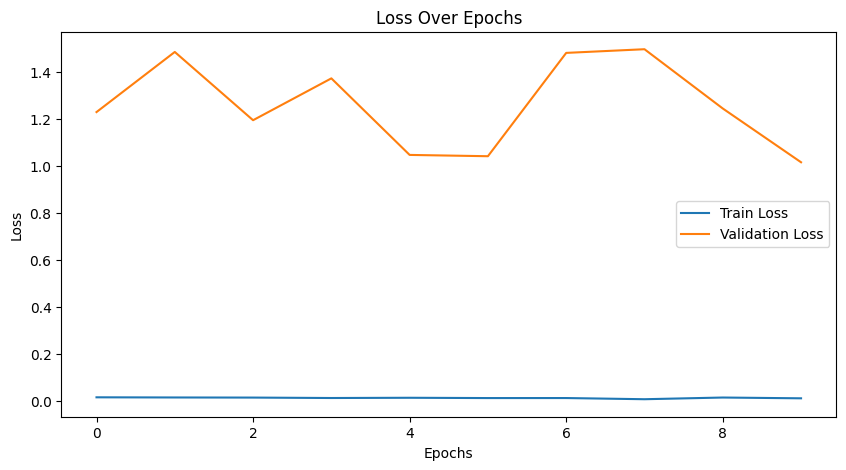

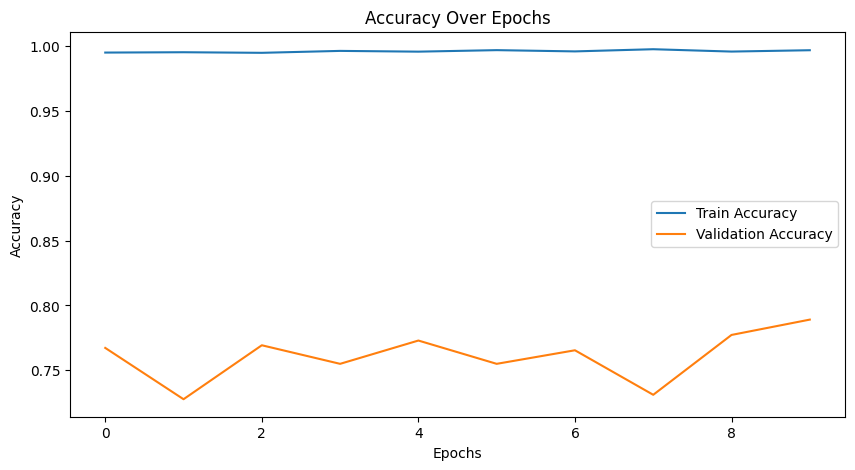

In [ ]:
# Kayıp grafiği
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.show()

# Doğruluk grafiği
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix

# Tahminler ve gerçek değerler
y_true = [0, 1, 1, 0, 1, 1, 0, 0, 1, 0]
y_pred = [0, 1, 0, 0, 1, 1, 0, 1, 1, 0]
y_prob = [0.1, 0.9, 0.4, 0.2, 0.8, 0.85, 0.05, 0.7, 0.95, 0.15]  # Modelin olasılık tahminleri

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Recall
recall = recall_score(y_true, y_pred)

# Precision
precision = precision_score(y_true, y_pred)

# Sensitivity = Recall
sensitivity = recall

# Specificity
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn + fp)

# F1 Score
f1 = f1_score(y_true, y_pred)

# AUC
auc = roc_auc_score(y_true, y_prob)

# Sonuçları yazdırma
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"F1 Score: {f1}")
print(f"AUC: {auc}")


Accuracy: 0.8
Recall: 0.8
Precision: 0.8
Sensitivity: 0.8
Specificity: 0.8
F1 Score: 0.8
AUC: 0.9600000000000001


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Test seti ve model tahminleri
y_true =  # Test setindeki gerçek sınıf etiketleri
y_pred = model.predict(X_test)  # Test setindeki tahminler
y_pred = np.argmax(y_pred, axis=1)  # Sınıf etiketlerine dönüştürme

# Karmaşıklık matrisi
cm = confusion_matrix(y_true, y_pred)

# Matrisin görselleştirilmesi
labels = ["Kizgin", "Mutlu", "Notr", "Saskin", "Uzgun"]  # Sınıf isimlerini belirleyin
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("Confusion Matrix for My Model")
plt.show()


NameError: name 'y_test' is not defined

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Tahmin edilen olasılık değerleri (örnek olarak pozitif sınıfa ait olasılıklar)
y_prob = [0.1, 0.9, 0.4, 0.2, 0.8, 0.85, 0.05, 0.7, 0.95, 0.15]

# ROC eğrisi
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

# AUC değeri
auc = roc_auc_score(y_true, y_prob)

# ROC eğrisinin görselleştirilmesi
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.show()
